In [1]:
### Imports
import sys
sys.path.insert(0, '/home/augustsemrau/drive/M1semester/02506_AdvancedImageAnalysis/02505miniproject')

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable


from src.model.U_NET_model import UNet
from src.model.model_train import train_model

from src.data.datasets import Dataset, DatasetPatch, set_seed

# U-Net training notebook

## Global Variables

In [2]:
MODEL_NAME = 'UNet'

## Load Data

In [14]:
# Make dataset class.
train_dataset = Dataset(train=True, augmentation_count=10)
val_dataset = Dataset(train=True, val=True)
test_dataset = Dataset(train=False)

/home/augustsemrau/drive/M1semester/02506_AdvancedImageAnalysis/02505miniproject/src/data/datasets.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images.append(torch.tensor(self._transform(image)))#, dtype=torch.float64))
/home/augustsemrau/drive/M1semester/02506_AdvancedImageAnalysis/02505miniproject/src/data/datasets.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels.append(torch.tensor(self._transform(label)))#, dtype=torch.float64))


KeyboardInterrupt: 

torch.Size([1, 128, 128])


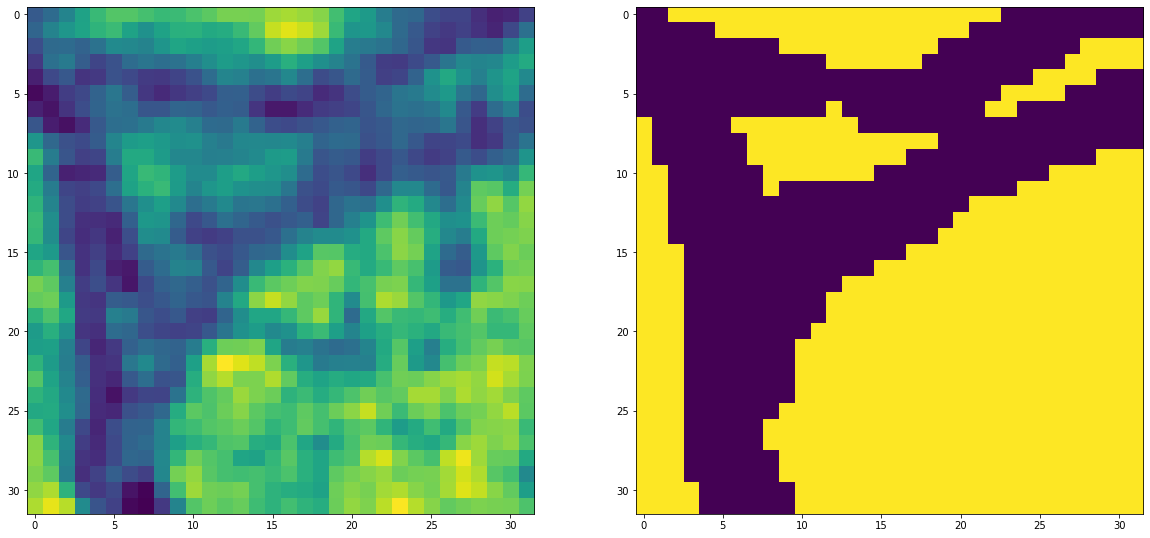

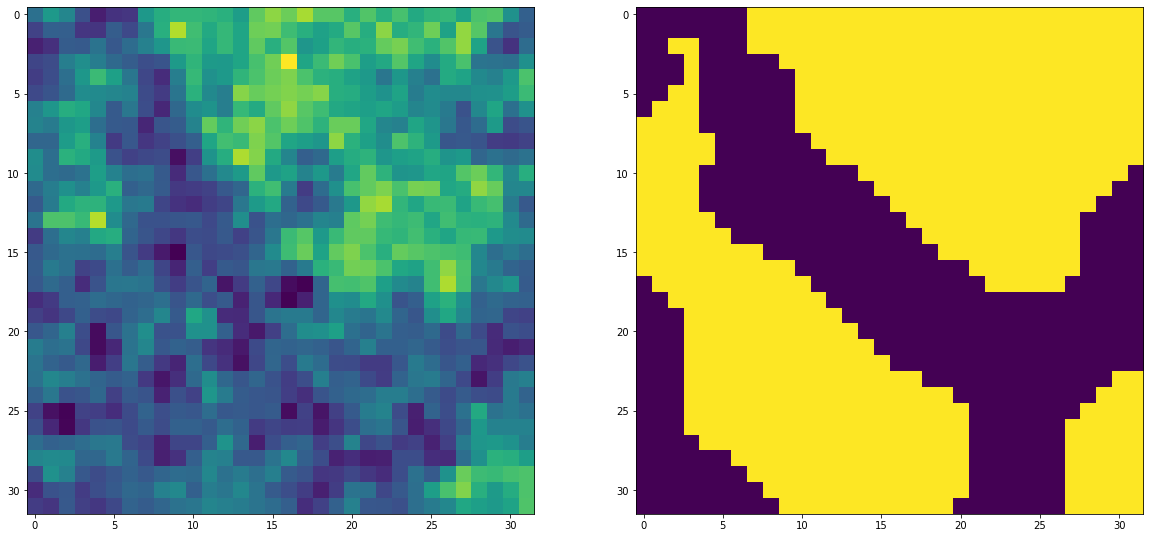

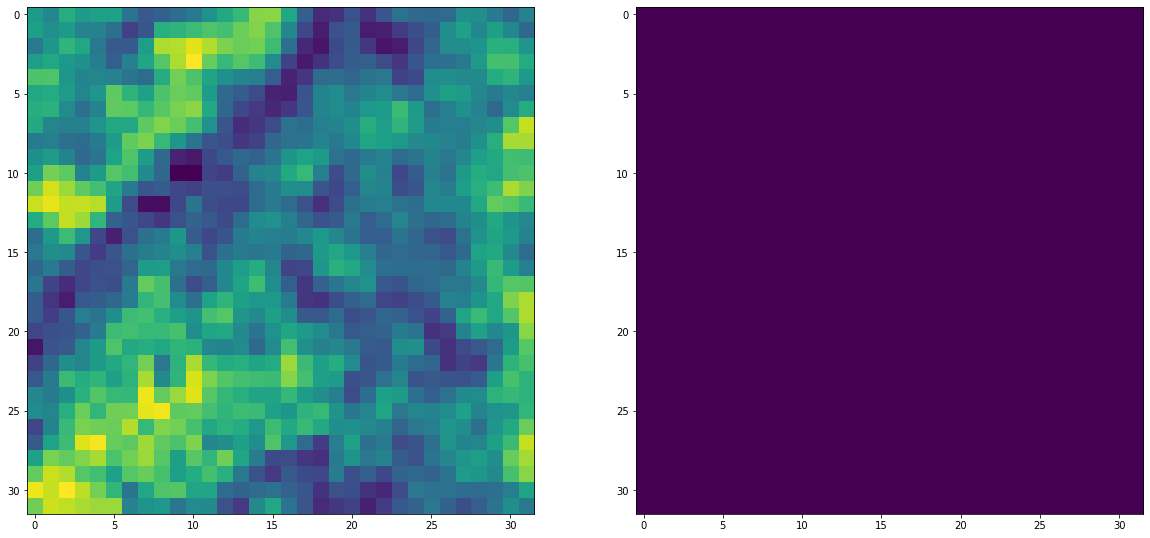

In [15]:
s = 128
train_dataset = DatasetPatch(train=True, size=s)
val_dataset = DatasetPatch(train=True, val=True, size=s)
test_dataset = DatasetPatch(train=False, size=s)

## Show some images from train, val and test sets
fig, ax = plt.subplots(1, 2, figsize=(20,10))
data_ex = train_dataset[23]
print(data_ex[0].shape)
ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10))
data_ex = val_dataset[3]
ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10))
data_ex = test_dataset[4]
ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

# Initialize and train U-Net
## First setup U-net

In [7]:
s = 128
train_dataset = DatasetPatch(train=True, size=s)
val_dataset = DatasetPatch(train=True, val=True, size=s)
# test_dataset = DatasetPatch(train=False, size=s)

## First we init the U-net
depth = 5
# Depth describes levels of unet - default is 5
model = UNet(num_classes=1, in_channels=1, depth=depth, merge_mode='concat')

set_seed(42)

# Test it works
# x = Variable(torch.FloatTensor(np.random.random((1, 1, 512, 512))))
x = Variable(torch.FloatTensor(np.random.random((1, 1, s, s))))
print(x)
out = model(x)
loss = torch.sum(out)
loss.backward()

print("Model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

tensor([[[[3.7454e-01, 9.5071e-01, 7.3199e-01,  ..., 4.2711e-01,
           8.1801e-01, 8.6073e-01],
          [6.9521e-03, 5.1075e-01, 4.1741e-01,  ..., 3.1692e-01,
           1.6949e-01, 5.5680e-01],
          [9.3615e-01, 6.9603e-01, 5.7006e-01,  ..., 6.9674e-01,
           6.2894e-01, 8.7747e-01],
          ...,
          [0.2908, 0.5167, 0.7222,  ..., 0.3578, 0.9747, 0.1724],
          [0.5067, 0.9408, 0.0381,  ..., 0.0352, 0.6746, 0.6631],
          [0.6024, 0.7291, 0.7291,  ..., 0.5242, 0.0067, 0.2575]]]])
Model parameters:  31030593


## Init optimizer and loss and start Model Training

In [8]:
# learning_rate = 0.8e-2
learning_rate = 3e-4
weight_decay = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

model, training_loss, validation_loss, global_steps = train_model(model=model, 
                                                                model_name=MODEL_NAME,
                                                                optimizer=optimizer, 
                                                                num_epochs=25, 
                                                                train_dataset=train_dataset, 
                                                                val_dataset=val_dataset, 
                                                                CUDA=False, 
                                                                SAVE_CHECKPOINTS=True,
                                                                size=s,
                                                                depth=depth)

Epoch 1/25
----------


100%|██████████| 24/24 [01:59<00:00,  5.00s/it]


Traning loss: 6.38483589887619
Validation loss 2.333594858646393
Epoch 2/25
----------


100%|██████████| 24/24 [02:11<00:00,  5.46s/it]


Traning loss: 2.9580570459365845
Validation loss 0.7502393126487732
Epoch 3/25
----------


100%|██████████| 24/24 [02:15<00:00,  5.64s/it]


Traning loss: 2.9581515789031982
Validation loss 0.7491757869720459
Epoch 4/25
----------


100%|██████████| 24/24 [02:13<00:00,  5.56s/it]


Traning loss: 2.9652106761932373
Validation loss 0.7496552467346191
Epoch 5/25
----------


100%|██████████| 24/24 [02:13<00:00,  5.58s/it]


tensor(0.9871, grad_fn=<MeanBackward0>)
tensor(204952)


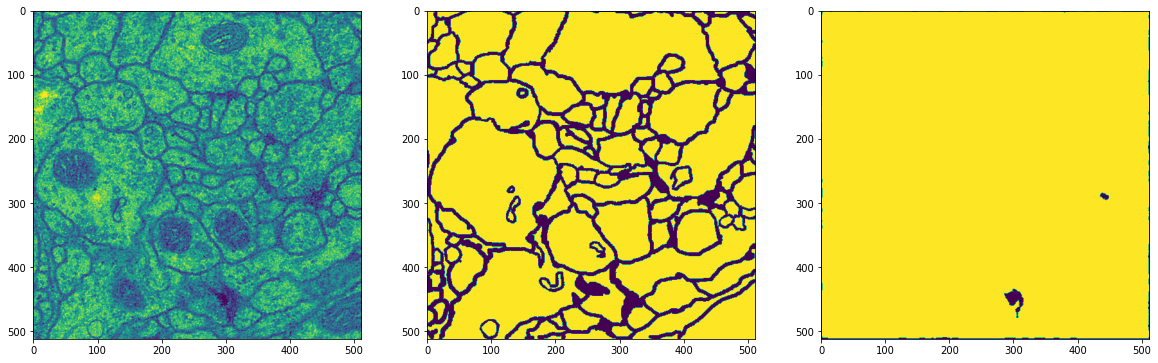

In [18]:
inputs = val_dataset[0][0].unsqueeze(0).float()
targets = val_dataset[0][1].unsqueeze(0)
pred = model(inputs)
pred[pred>=0.9991] = 1
pred[pred<0.9991] = 0
print(pred.mean())
print(targets.sum())
fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(inputs.squeeze(0).cpu().numpy()[0,:,:])
ax[1].imshow(targets.squeeze(0).cpu().numpy()[0,:,:])
ax[2].imshow(pred.squeeze(0).detach().numpy()[0,:,:])
plt.show()
# plt.imshow(pred.squeeze(0).detach().numpy()[0,:,:])

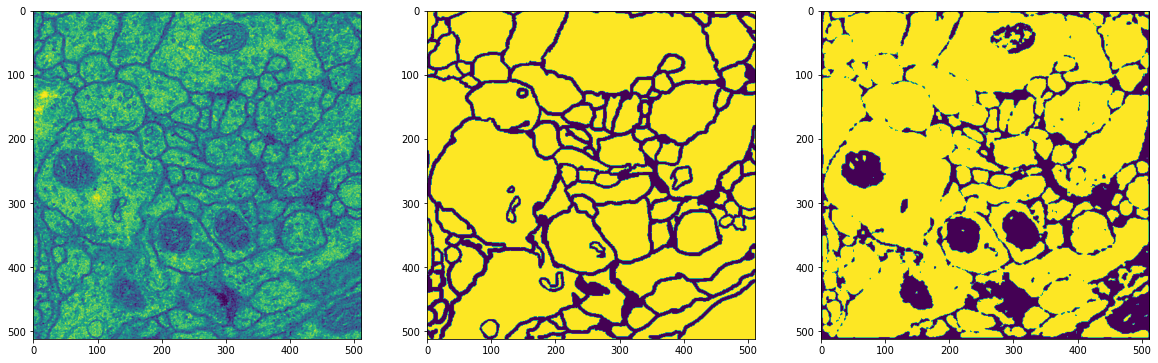

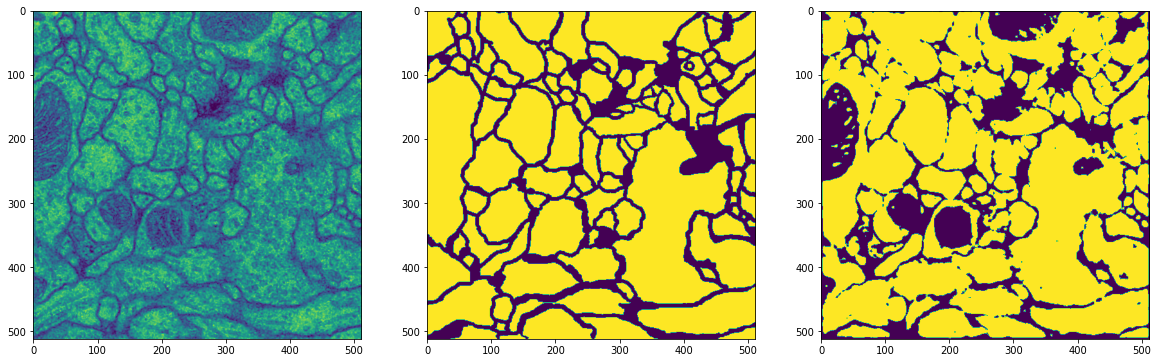

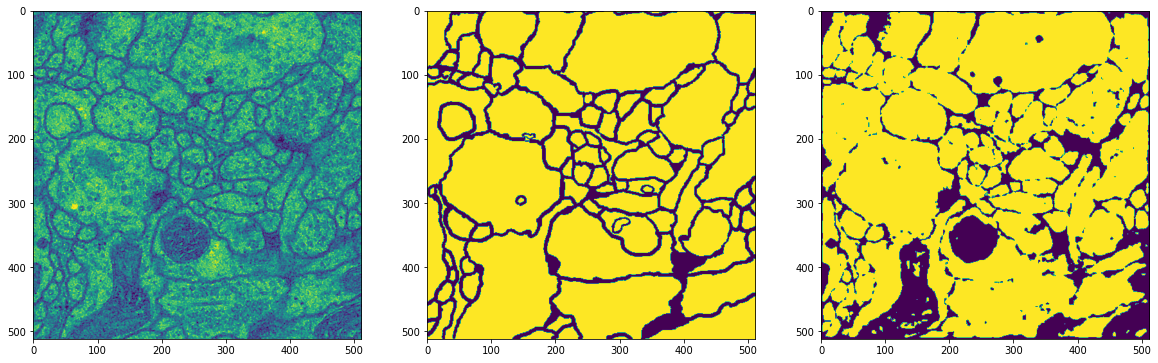

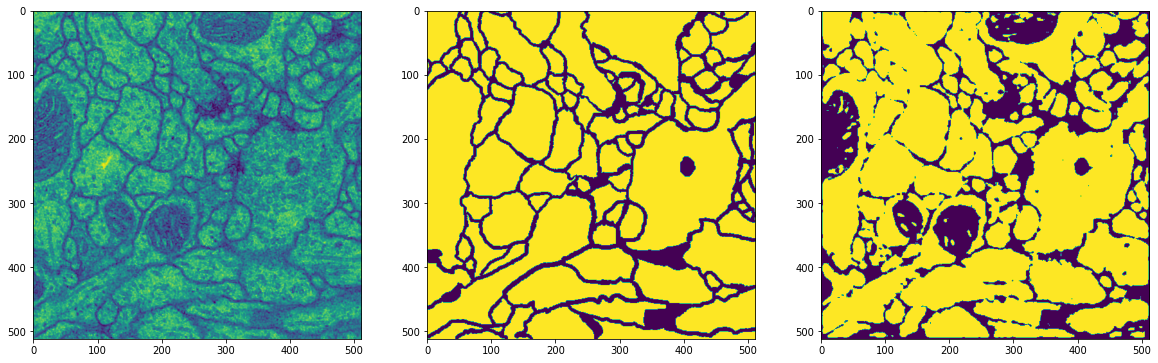

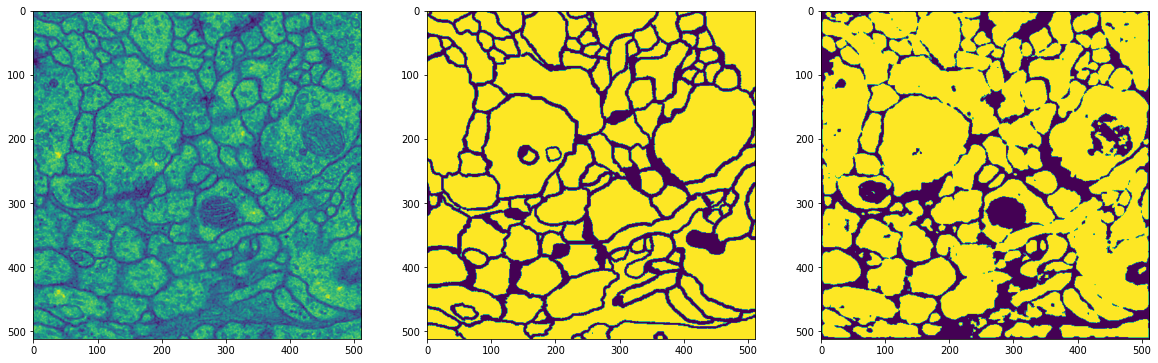

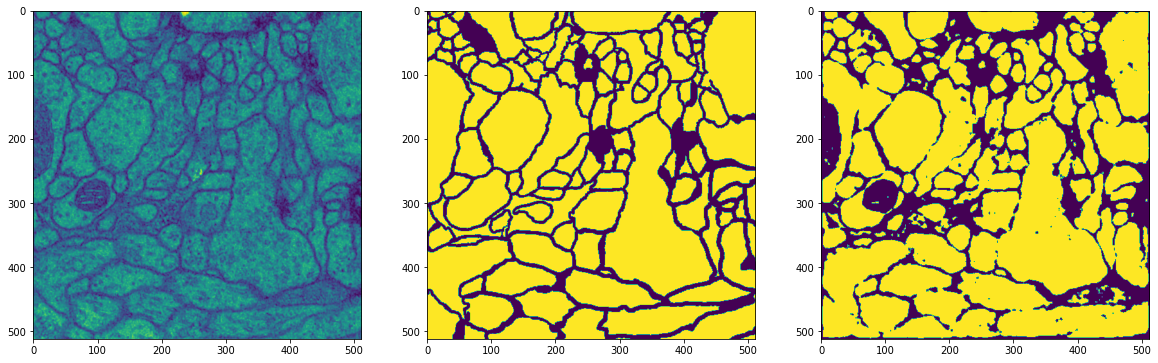

In [9]:
for inputs, targets in val_dataset:
    inputs=inputs.unsqueeze(0)
    inputs = inputs.float()
    targets=targets.unsqueeze(0)
    y_hat = model(inputs)
    y_hat_mean = y_hat.mean()
    y_hat[y_hat>y_hat_mean] = 1
    y_hat[y_hat<=y_hat_mean] = 0
    # print(targets.shape)
    # print(y_hat.shape)
    # npgrid = torchvision.utils.make_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0))
    # print(npgrid.shape)
    # plt.figure(figsize=(20,20))
    # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    # print(inputs)
    # print(targets)
    # print(y_hat.squeeze(0).detach().numpy()[0,:,:])
    fig, ax = plt.subplots(1, 3, figsize=(20,10))
    ax[0].imshow(inputs.squeeze(0).cpu().numpy()[0,:,:])
    ax[1].imshow(targets.squeeze(0).cpu().numpy()[0,:,:])
    ax[2].imshow(y_hat.squeeze(0).detach().numpy()[0,:,:])
    plt.show()

In [27]:
# np.transpose(npgrid, (1, 2, 0)).shape

NameError: name 'npgrid' is not defined

# Extra

In [ ]:
# def plot_images_grid(x: torch.tensor, export_img, title: str = '', nrow=8, padding=2, normalize=False, pad_value=0):
#     """Plot 4D Tensor of images of shape (B x C x H x W) as a grid."""

#     grid = torchvision.utils.make_grid(x, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value)
#     npgrid = grid.cpu().numpy()

#     plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

#     ax = plt.gca()
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)

#     if not (title == ''):
#         plt.title(title)

#     plt.savefig(export_img, bbox_inches='tight', pad_inches=0.1)
#     plt.clf()

# # Example usage
# plot_images_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0), 'test.png')